In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress, pearsonr
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [ ]:
from lib.utils import get_phi_psi_dist, find_kdepeak, calc_da
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from numpy.linalg import LinAlgError

max_clusters = 7

proteins = [
	'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
	'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]

rows = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
    da.load_results()
    for seq in tqdm(da.xray_phi_psi.seq_ctxt.unique()):
        if 'X' in seq:
            print('Skipping', protein, seq, '\t[Contains X]')
            continue
        phi_psi_dist, info = get_phi_psi_dist(da.queries, seq)
        if phi_psi_dist.shape[0] < 2: 
            print('Skipping', protein, seq, '\t[Not enough samples]')
            continue
        xray = da.xray_phi_psi.loc[da.xray_phi_psi.seq_ctxt == seq][['phi','psi']]
        if xray.shape[0] == 0:
            print('Skipping', protein, seq, '\t[No Xray]')
            continue
        xray = xray.iloc[0].values

        max_sil_avg = -1
        one_cluster_wss = -1
        for k in range(1, min(phi_psi_dist.shape[0], max_clusters)):
            kmeans = KMeans(n_clusters=k, n_init=10)
            labels = kmeans.fit_predict(phi_psi_dist[['phi', 'psi']])
            wss = kmeans.inertia_
            if k == 1:
                one_cluster_wss = wss
                phi_psi_dist['cluster'] = labels
                continue

            elif k == 2:
                if wss >= one_cluster_wss:
                    break

            sil_avg = silhouette_score(phi_psi_dist[['phi', 'psi']], labels)
            if sil_avg > max_sil_avg:
                max_sil_avg = sil_avg
                phi_psi_dist['cluster'] = labels
        
        peaks = []
        cs = phi_psi_dist.cluster.unique()
        for c in cs:
            if phi_psi_dist.loc[phi_psi_dist.cluster == c].shape[0] < 2:
                continue
            try:
                kdepeak = find_kdepeak(phi_psi_dist.loc[phi_psi_dist.cluster == c], 0.5)
            except LinAlgError:
                continue
            peaks.append(kdepeak)
        peaks = np.array(peaks)

        dists = calc_da(xray, peaks)
        min_dist = np.min(dists)
        chosen_peak = peaks[np.argmin(dists)]
        chosen_c = cs[np.argmin(dists)]
        cluster = phi_psi_dist.loc[phi_psi_dist.cluster == chosen_c, ['phi', 'psi']].values
        cluster_std = np.std(cluster, axis=0)

        n_samples = [infoi[2] for infoi in info]
        dists = list(np.pad(dists, (0, max_clusters - len(dists)), 'constant', constant_values=-1).round(3))
        rows.append([
            protein, seq, min_dist.round(3), 
            xray[0].round(3), xray[1].round(3), 
            chosen_peak[0].round(3), chosen_peak[1].round(3),
            max_sil_avg,
            *cluster_std, *n_samples, *dists
        ])

        # sns.scatterplot(x='phi', y='psi', hue='cluster', data=phi_psi_dist)
        # plt.scatter([p[0] for p in peaks], [p[1] for p in peaks], marker='x')
        # plt.scatter(xray[0], xray[1], marker='x')
        # plt.show()

    df = pd.DataFrame(rows, columns=[
        'protein', 'seq', 'min_dist', 'xray_phi', 'xray_psi', 
        'chosen_peak_phi', 'chosen_peak_psi', 
        'cluster_std_phi', 'cluster_std_psi',
        'kmeans_silhouette',
        'win4', 'win5', 'win6', 'win7', 
        'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6', 'dist_7'
    ])
    df.to_csv(f'quantative_analysis.csv', index=False)

In [12]:
df = pd.read_csv('quantative_analysis.csv')

<Axes: xlabel='min_dist', ylabel='Count'>

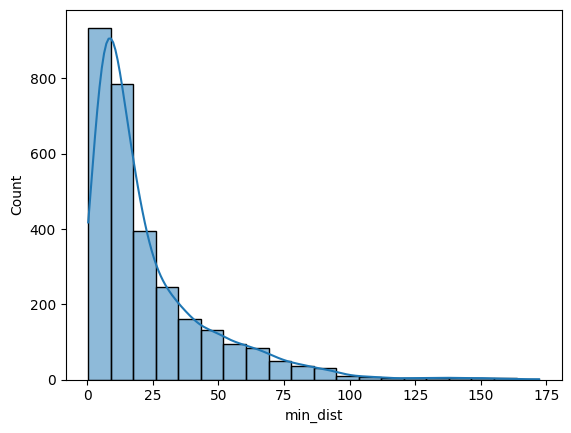

In [43]:
# sns.kdeplot(df.min_dist, fill=True)
# sns.histplot(df, x='min_dist', bins=20, hue='protein', multiple='stack')
sns.histplot(df, x='min_dist', bins=20, kde=True)

Text(0.5, 0.98, 'Distance of X-Ray to KDE peak of Nearest Cluster (All Proteins, ~3000 residues)')

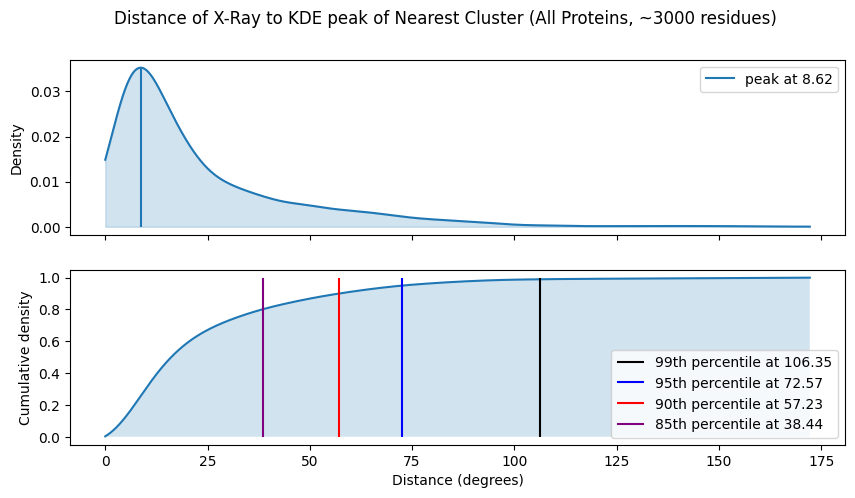

In [72]:
from scipy.stats import gaussian_kde
def get_probs(x, da):
    
    kde = gaussian_kde(da)
    p = kde(x)
    c = np.cumsum(p) / np.sum(p)
    peak = x[np.argmax(p)]
    return p, c, peak

def plot(values, label, color):
    p, c, peak = get_probs(x, values)
    axes[0].plot(x, p, color=color, label=f'peak at {peak:.2f}')
    axes[0].fill_between(x, 0, p, alpha=0.2, color=color)
    axes[0].vlines(peak, 0, p.max(), color=color)
    axes[1].plot(x, c, color=color)

    perc = x[np.argmax(c > 0.99)]
    axes[1].vlines(perc, 0, 1, color='black', label=f'99th percentile at {perc:.2f}')
    perc = x[np.argmax(c > 0.95)]
    axes[1].vlines(perc, 0, 1, color='blue', label=f'95th percentile at {perc:.2f}')
    perc = x[np.argmax(c > 0.90)]
    axes[1].vlines(perc, 0, 1, color='red', label=f'90th percentile at {perc:.2f}')
    perc = x[np.argmax(c > 0.80)]
    axes[1].vlines(perc, 0, 1, color='purple', label=f'85th percentile at {perc:.2f}')
    axes[1].fill_between(x, 0, c, alpha=0.2)

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
x = np.linspace(0, df.min_dist.max(), 1000)
colors = sns.color_palette("tab10")
plot(df.min_dist, 'Xray', colors[0])
axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Distance (degrees)')
axes[1].set_ylabel('Cumulative density')
# axes[0].set_xlim(0, 5000)
# axes[1].set_xlim(0, 5000)
fig.suptitle('Distance of X-Ray to KDE peak of Nearest Cluster (All Proteins, ~3000 residues)')

In [95]:
df.win4.mean()

2524.576435246996

In [138]:
df.sort_values('min_dist').tail(10)

,protein,seq,min_dist,xray_phi,xray_psi,chosen_peak_phi,chosen_peak_psi,cluster_std_phi,cluster_std_psi,kmeans_silhouette,...,win6,win7,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,cluster_std
2932,T1058-D2,TRLDYDR,140.864,-135.345,-172.674,-82.730,56.657,0.653576,31.449446,31.290212,...,0,0,140.864,155.110,214.805,-1.0,-1.0,-1.0,-1.0,31.456237
1051,T1032-D1,KITHCPT,144.431,-68.469,143.522,-94.763,1.504,0.566040,35.898785,72.859877,...,0,0,144.431,200.972,-1.000,-1.0,-1.0,-1.0,-1.0,35.903247
1539,T1029-D1,QGSSIEG,147.402,65.720,177.913,-154.930,129.861,0.795261,42.240641,24.044654,...,126,20,199.356,147.402,-1.000,-1.0,-1.0,-1.0,-1.0,42.248127
27,T1024,FSSMTIY,149.844,-67.640,-23.411,-76.713,-172.981,0.743973,36.079481,70.945787,...,0,0,177.920,149.844,-1.000,-1.0,-1.0,-1.0,-1.0,36.087150
762,T1024-D1,FSSMTIY,149.844,-67.640,-23.411,-76.713,-172.981,0.743973,36.079481,70.945787,...,0,0,177.920,149.844,-1.000,-1.0,-1.0,-1.0,-1.0,36.087150
2368,T1053-D2,KDSKLRT,151.189,81.079,-6.611,-66.685,-38.607,0.771011,26.507731,22.989331,...,0,0,151.189,238.284,-1.000,-1.0,-1.0,-1.0,-1.0,26.518942
1146,T1053-D1,DDEERLV,155.872,55.645,58.676,-63.677,-41.616,0.832641,21.257427,19.513070,...,0,0,155.872,185.682,-1.000,-1.0,-1.0,-1.0,-1.0,21.273728
2896,T1058-D2,PREAGAK,158.908,68.526,-62.739,-79.721,-5.515,0.762065,22.271079,23.935898,...,28,0,158.908,209.771,-1.000,-1.0,-1.0,-1.0,-1.0,22.284113
1467,T1027-D1,GRCHTYE,162.649,64.837,26.871,-57.660,133.872,0.868862,15.975931,10.493811,...,0,0,162.649,168.854,-1.000,-1.0,-1.0,-1.0,-1.0,15.999540
1111,T1053-D1,PKNHYPE,172.202,65.683,-162.239,63.677,25.571,0.831539,12.479806,56.747885,...,0,0,183.585,195.753,172.202,-1.0,-1.0,-1.0,-1.0,12.507478


In [143]:
da = DihedralAdherence('T1032-D1', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
da.load_results()

Initializing T1032-D1 ...
Results already exist
Casp ID: T1032-D1 	PDB: 6n64
Structure exists: 'pdb/pdb6n64.ent' 
UniProt ID: Q6P5D8


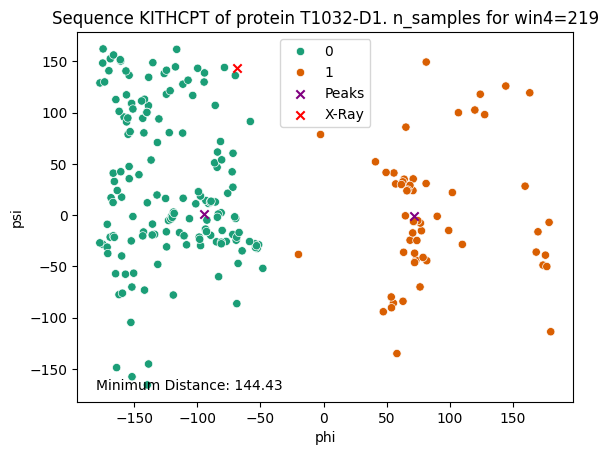

In [144]:
seq = 'KITHCPT'
phi_psi_dist, info = get_phi_psi_dist(da.queries, seq)
xray = da.xray_phi_psi.loc[da.xray_phi_psi.seq_ctxt == seq][['phi','psi']]
xray = xray.iloc[0].values

max_sil_avg = -1
one_cluster_wss = -1
for k in range(1, min(phi_psi_dist.shape[0], max_clusters)):
    kmeans = KMeans(n_clusters=k, n_init=10)
    labels = kmeans.fit_predict(phi_psi_dist[['phi', 'psi']])
    wss = kmeans.inertia_
    if k == 1:
        one_cluster_wss = wss
        phi_psi_dist['cluster'] = labels
        continue

    elif k == 2:
        if wss >= one_cluster_wss:
            break

    sil_avg = silhouette_score(phi_psi_dist[['phi', 'psi']], labels)
    if sil_avg > max_sil_avg:
        max_sil_avg = sil_avg
        phi_psi_dist['cluster'] = labels

peaks = []
cs = phi_psi_dist.cluster.unique()
for c in cs:
    if phi_psi_dist.loc[phi_psi_dist.cluster == c].shape[0] < 2:
        continue
    try:
        kdepeak = find_kdepeak(phi_psi_dist.loc[phi_psi_dist.cluster == c], 0.5)
    except LinAlgError:
        continue
    peaks.append(kdepeak)
peaks = np.array(peaks)

dists = calc_da(xray, peaks)
sns.scatterplot(x='phi', y='psi', hue='cluster', data=phi_psi_dist, palette='Dark2')
plt.scatter([p[0] for p in peaks], [p[1] for p in peaks], color='purple', marker='x', label='Peaks')
plt.scatter(xray[0], xray[1], marker='x', color='red', label='X-Ray')
plt.title(f'Sequence {seq} of protein {da.casp_protein_id}. n_samples for win4={info[0][2]}')
plt.text(-180, -170, f'Minimum Distance: {np.min(dists):.2f}')
plt.legend()
plt.show()

# Analyze by neighbors

In [ ]:
from lib.utils import get_phi_psi_dist, find_kdepeak, calc_da
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from numpy.linalg import LinAlgError

thresholds = [10, 30, 60, 90, 120, 150, 180]

proteins = [
	'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
	'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]

rows = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
    da.load_results()
    for seq in tqdm(da.xray_phi_psi.seq_ctxt.unique()[2:]):
        if 'X' in seq:
            print('Skipping', protein, seq, '\t[Contains X]')
            continue
        phi_psi_dist, info = get_phi_psi_dist(da.queries, seq)
        if phi_psi_dist.shape[0] < 2: 
            print('Skipping', protein, seq, '\t[Not enough samples]')
            continue
        xray = da.xray_phi_psi.loc[da.xray_phi_psi.seq_ctxt == seq][['phi','psi']]
        if xray.shape[0] == 0:
            print('Skipping', protein, seq, '\t[No Xray]')
            continue
        xray = xray.iloc[0].values
        dists = calc_da(xray, phi_psi_dist[['phi', 'psi']].values)
        n_neighbors = [np.sum(dists < t) for t in thresholds]

        n_samples = [infoi[2] for infoi in info]

        rows.append([
            protein, seq, 
            xray[0].round(3), xray[1].round(3), 
            *n_neighbors, *n_samples
        ])
    df = pd.DataFrame(rows, columns=[
        'protein', 'seq', 
        'xray_phi', 'xray_psi', 
        *[f'n_neighbors_{t}' for t in thresholds],
        'win4', 'win5', 'win6', 'win7', 
    ])
    df.to_csv(f'quantative_analysis_neighbors.csv', index=False)

In [202]:
df = pd.read_csv('quantative_analysis_neighbors.csv')

## Summary
- ~3000 residues
- 4% (119) of them are cases where pdbmine finds no phi-psi pairs within 10 degrees of xray
- 0.6% (18) of them are cases where pdbmine finds no phi-psi pairs within 30 degrees of xray
- On average, PDBMine find window size of 2525 matches for a window size of 4 (median 1941)
- In the 4% case, this is on average 1008 (median 589)

In [207]:
df[df.n_neighbors_30 == 0].win4.median()

205.0

In [209]:
df[df.n_neighbors_30 == 0].sort_values('win4').tail(10)

,protein,seq,xray_phi,xray_psi,n_neighbors_10,n_neighbors_30,n_neighbors_60,n_neighbors_90,n_neighbors_120,n_neighbors_150,n_neighbors_180,win4,win5,win6,win7
1099,T1053-D1,PKNHYPE,65.683,-162.239,0,0,1,1,1,4,73,186,4,0,0
2679,T1058-D1,WAACCFQ,-80.080,113.383,0,0,33,41,101,176,266,224,42,0,0
2043,T1028-D1,QGPMPQT,-132.078,-103.144,0,0,0,274,461,504,522,229,151,147,2
2701,T1058-D1,TLPGNWG,-179.874,-132.695,0,0,22,97,127,168,248,266,4,0,0
1178,T1053-D1,IEKSFME,52.002,69.980,0,0,0,0,4,52,332,418,3,1,0
2298,T1053-D2,VSTFHVV,-88.072,15.697,0,0,22,100,220,477,520,518,3,0,0
2463,T1057-D1,VGFREYR,-116.750,-8.144,0,0,168,491,504,545,677,665,18,0,0
1507,T1029-D1,SQANRRR,-136.999,-76.750,0,0,16,567,764,825,979,933,60,20,20
1384,T1053-D1,QNITIFS,-104.196,-82.001,0,0,334,577,628,1412,2901,2835,71,0,0
1488,T1029-D1,IDELVPA,-103.873,-114.581,0,0,41,1002,2829,3852,3968,3820,132,22,20


In [ ]:
df.loc[df.n_neighbors_10 == 0, ['protein', 'seq', 'n_neighbors_60', 'win4']]

Initializing T1029-D1 ...
Results already exist
Casp ID: T1029-D1 	PDB: 6uf2
Structure exists: 'pdb/pdb6uf2.ent' 
UniProt ID: Q31PX7
[(4, 'ANRR', 933, 1), (5, 'QANRR', 60, 32), (6, 'QANRRR', 20, 64), (7, 'SQANRRR', 20, 128)]


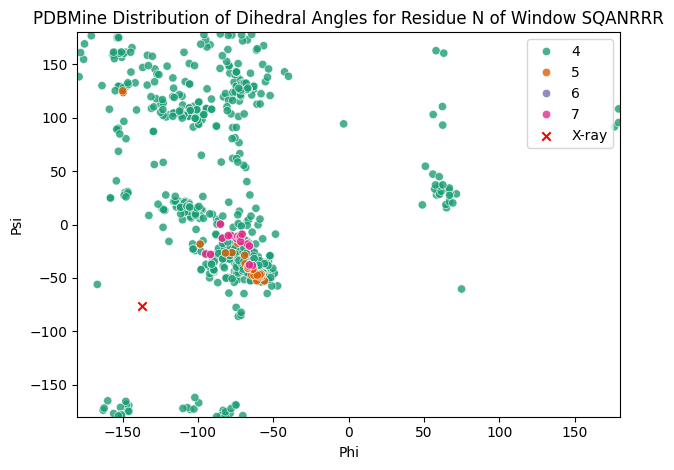

In [212]:
da = DihedralAdherence('T1029-D1', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
da.load_results()
phi_psi_dist, info = get_phi_psi_dist(da.queries, 'SQANRRR')
print(info)
da.plot_one_dist_scatter('SQANRRR')